In [ ]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.layers import *
import tensorflow_hub as hub
#!pip install tensorflow_text
import tensorflow_text as text
import matplotlib.pyplot as plt
import matplotlib

In [2]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('test.csv')
test_df = pd.read_csv('val.csv')

train_df = train_df.drop(['Unnamed: 0'],axis=1)
test_df = test_df.drop(['Unnamed: 0'],axis=1)
val_df = val_df.drop(['Unnamed: 0'],axis=1)

In [3]:
x_train = train_df['Utterances'].to_numpy()
x_train = np.asarray(x_train).astype(str)
y_train = pd.get_dummies(train_df['Basic']).values
y_train = np.asarray(y_train).astype('float32')

x_val = val_df['Utterances'].to_numpy()
x_val = np.asarray(x_val).astype(str)
y_val = pd.get_dummies(val_df['Basic']).values
y_val = np.asarray(y_val).astype('float32')

x_test = test_df['Utterances'].to_numpy()
x_test = np.asarray(x_test).astype(str)
y_test = pd.get_dummies(test_df['Basic']).values
y_test = np.asarray(y_test).astype('float32')

In [4]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [12]:
### Bert encoding layers
text_input = Input(shape=(),dtype=tf.string,name='Text')
preprocess_text = bert_preprocess(text_input)
encode_output = bert_encoder(preprocess_text)['encoder_outputs'][11]#output of the last encoded layer

### bilstm
bilstm = Bidirectional(CuDNNLSTM(
    units=128,
    return_sequences=False))(encode_output)

###Output
output = Dense(5,activation='softmax')(bilstm)

In [13]:
model=keras.Model(text_input,output)

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['Text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               mode='auto', 
                                               patience=3, 
                                               verbose=1)

In [17]:
hist = model.fit(x_train, y_train, 
          epochs=100, 
          batch_size=32, 
          verbose=1,
          callbacks=[early_stopping],
          validation_data=(x_val, y_val))

Epoch 1/100
2346/2346 [==============================] - 970s 412ms/step - loss: 0.2840 - accuracy: 0.8919 - val_loss: 0.2621 - val_accuracy: 0.8990
Epoch 2/100
2346/2346 [==============================] - 964s 411ms/step - loss: 0.2537 - accuracy: 0.9012 - val_loss: 0.2630 - val_accuracy: 0.8941
Epoch 3/100
2346/2346 [==============================] - 975s 416ms/step - loss: 0.2475 - accuracy: 0.9031 - val_loss: 0.2584 - val_accuracy: 0.8986
Epoch 4/100
2346/2346 [==============================] - 983s 419ms/step - loss: 0.2438 - accuracy: 0.9030 - val_loss: 0.2536 - val_accuracy: 0.9005
Epoch 5/100
2346/2346 [==============================] - 984s 419ms/step - loss: 0.2412 - accuracy: 0.9035 - val_loss: 0.2609 - val_accuracy: 0.8983
Epoch 6/100
2346/2346 [==============================] - 983s 419ms/step - loss: 0.2383 - accuracy: 0.9039 - val_loss: 0.2617 - val_accuracy: 0.8997
Epoch 7/100
2346/2346 [==============================] - 983s 419ms/step - loss: 0.2349 - accuracy: 0.9053

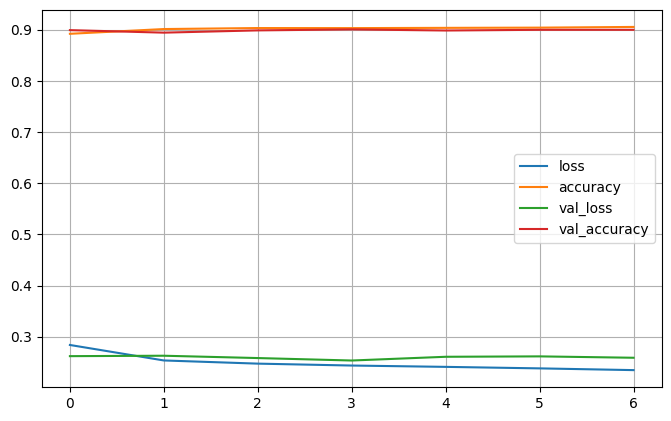

In [18]:
matplotlib.rcParams['figure.dpi'] = 100

def plot(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()
    
plot(hist)

In [22]:
model.evaluate(x_test, y_test)

514/514 [==============================] - 173s 337ms/step - loss: 0.3589 - accuracy: 0.8793


[0.3588513433933258, 0.8793208599090576]

In [23]:
y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[1892    0   18    0  292]
 [ 119 1895  256   21  179]
 [ 180   34  779    0   92]
 [   0    0    0 1095   17]
 [ 750    3   15    7 8788]]


In [24]:
from sklearn.metrics import f1_score
print("F1 score(macro)",f1_score(y_test, y_pred, average='macro'))
print("F1 score(micro)",f1_score(y_test, y_pred, average='micro'))

F1 score(macro) 0.8457322210825353
F1 score(micro) 0.8793208373904576


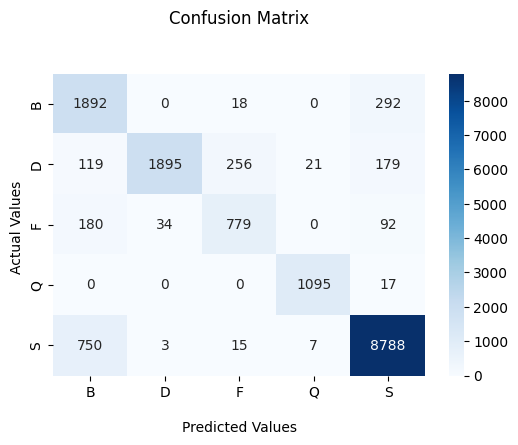

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d')
ax.xaxis.set_ticklabels(['B','D','F','Q','S'])
ax.yaxis.set_ticklabels(['B','D','F','Q','S'])
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Display the visualization of the Confusion Matrix.
plt.show()

In [26]:
labels=(['B','D','F','Q','S'])
labels[np.argmax(model.predict(['Who are you?']))]

'Q'